# Master thesis - Imbalanced learning and model interpretation in credit scoring

620146 Sinan Wang

# Table of Contents

    1. Load Data and artificial dataset construction
       1.1 Load data
       1.2 IR inspection
       1.3 Artificial dataset Construction
    2. Data clean and EDA
       2.1 Numerical feature clean and EDA
       2.2 Categorical features clean and EDA
    3. Splitting data and Feature Engineering
       3.1 Split data
       3.2 Feature engineer
           3.2.1 Standardise numerical variables
           3.2.2 Target encoding categorical variables
    4. Obtain resampling data
    5. Model training
       5.1 Random forest
       5.2 Neural network
       5.3 Logit
           5.3.1 Logit training
           5.3.2 Apply resampling methods on Logit
       5.4 XGBoost
           5.4.1 XGBoost training
           5.4.2 Apply resampling methods on XGBoost
    6. XAI
       6.1 SHAP fearure importance
           6.1.1 Calculate SHAP feature importance
           6.1.2 SHAP rank correlation
           6.1.3 SHAP feature importance visualisation
       6.2 PFI
           6.2.1 Calculate PFI
           6.2.2 PFI rank correlation
           6.2.3 PFI feature importance visualisation

In [1]:
# Inspecting dataport libraires
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders.target_encoder import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_auc_score
from imblearn.metrics import geometric_mean_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier
import shap
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from imblearn.under_sampling import InstanceHardnessThreshold
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import NearMiss
from imblearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.linear_model import LogisticRegressionCV
import xgboost as xgb
from tensorflow import keras
from tensorflow.keras import Input,layers
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(1)

%load_ext autoreload
%autoreload 2

# 1. Load Data and artificial dataset construction

## 1.1 Load data

In [2]:
#read df
hmeq_ori = pd.read_csv("../data/hmeq.txt")

#change column names
hmeq_ori.rename(columns={'BAD': 'target'},
                inplace=True)

print(hmeq_ori.shape)
print(hmeq_ori.info())

(5960, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   target   5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB
None


## 1.2 IR inspection

In [3]:
hmeq_ori.target.value_counts()

0    4771
1    1189
Name: target, dtype: int64

In [4]:
IR_ori = round(len(hmeq_ori.loc[hmeq_ori['target'] == 0])/len(hmeq_ori.loc[hmeq_ori['target'] == 1]),2)
print('The imbalance ratio of the original data set is '+ str(IR_ori))

The imbalance ratio of the original data set is 4.01


<AxesSubplot:ylabel='target'>

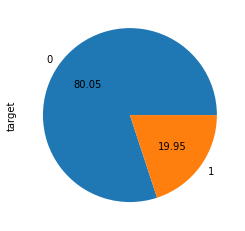

In [5]:
hmeq_ori.target.value_counts().plot.pie(autopct = "%.2f")

## 1.3 Artificial dataset Construction

In [6]:
minority = hmeq_ori[hmeq_ori['target']==1]
majority = hmeq_ori[hmeq_ori['target']==0]

In [7]:
#randomly remove minority class to achieve IR=20
np.random.seed(10)
remove_n = int(minority.shape[0] - majority.shape[0]/20)
drop_indices = np.random.choice(minority.index, remove_n, replace=False)
minority_art = minority.drop(drop_indices)
print(minority_art.shape) 

(239, 13)


In [8]:
#obtain constructed artifical data set
hmeq = pd.concat([majority, minority_art])
IR_art = round(len(hmeq.loc[hmeq['target'] == 0])/len(hmeq.loc[hmeq['target'] == 1]),2)

print(hmeq.shape)
print(hmeq.target.value_counts())
print('The imbalance ratio of artificial data set is '+ str(IR_art))

(5010, 13)
0    4771
1     239
Name: target, dtype: int64
The imbalance ratio of artificial data set is 19.96


# 2. Data clean and EDA

## 2.1 Numerical feature clean and EDA

In [9]:
#numerical variables 
numvars = ['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 
           'DELINQ', 'CLAGE', 'NINQ','DEBTINC']
hmeq[numvars].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5010 entries, 4 to 5896
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   LOAN     5010 non-null   int64  
 1   MORTDUE  4575 non-null   float64
 2   VALUE    4977 non-null   float64
 3   YOJ      4544 non-null   float64
 4   DEROG    4369 non-null   float64
 5   DELINQ   4484 non-null   float64
 6   CLAGE    4761 non-null   float64
 7   NINQ     4557 non-null   float64
 8   DEBTINC  4369 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 391.4 KB


### Check the missing values

In [10]:
print(hmeq[numvars].isnull().sum() )

LOAN         0
MORTDUE    435
VALUE       33
YOJ        466
DEROG      641
DELINQ     526
CLAGE      249
NINQ       453
DEBTINC    641
dtype: int64


In [11]:
for col in numvars:  # loop over all numeric columns
    if hmeq[col].isna().sum() > 0:                        
        m = hmeq[col].median(skipna=True)                  
        hmeq[col].fillna(m, inplace=True)                 

In [12]:
#check the missing values
print(hmeq[numvars].isnull().sum() )

LOAN       0
MORTDUE    0
VALUE      0
YOJ        0
DEROG      0
DELINQ     0
CLAGE      0
NINQ       0
DEBTINC    0
dtype: int64


### EDA

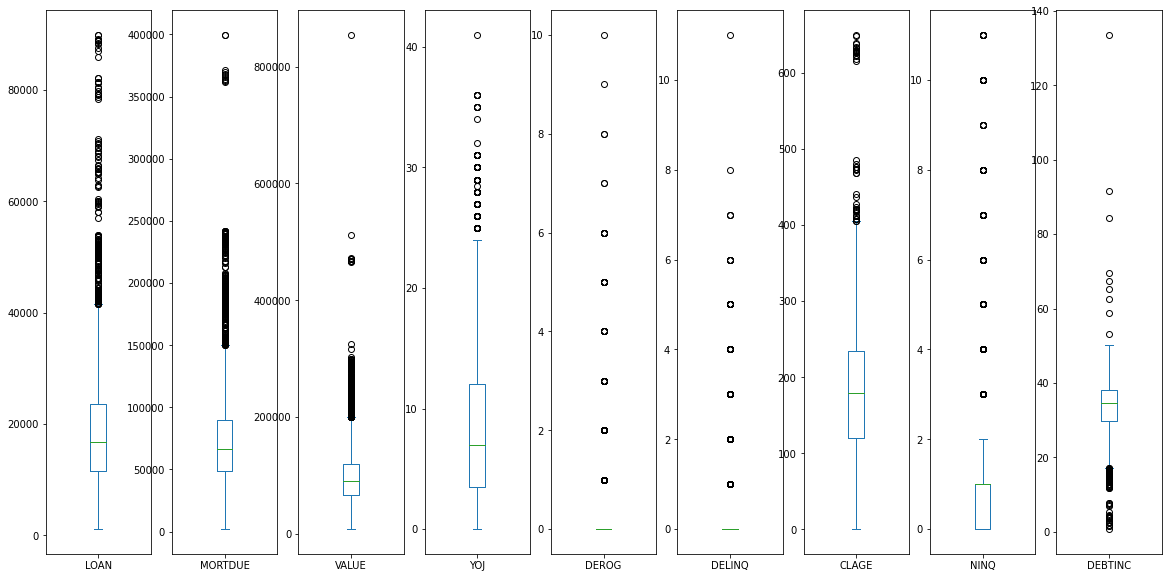

In [13]:
#check the distribution
plt.rcParams["figure.figsize"] = (20,10)
num_vars = hmeq[numvars]
num_vars.plot(kind = 'box', subplots=True);
#some outliers- but reasonable

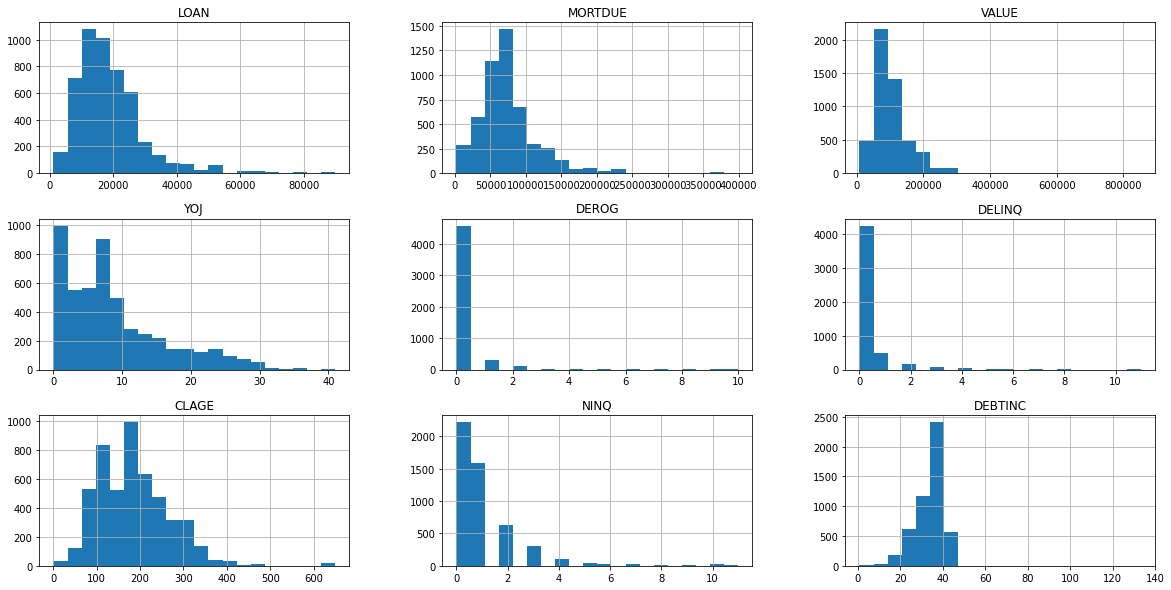

In [14]:
hmeq[numvars].hist(bins=20);

### Check the correlation

In [15]:
all_num = ['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 
           'DELINQ', 'CLAGE', 'NINQ','DEBTINC', 'target']

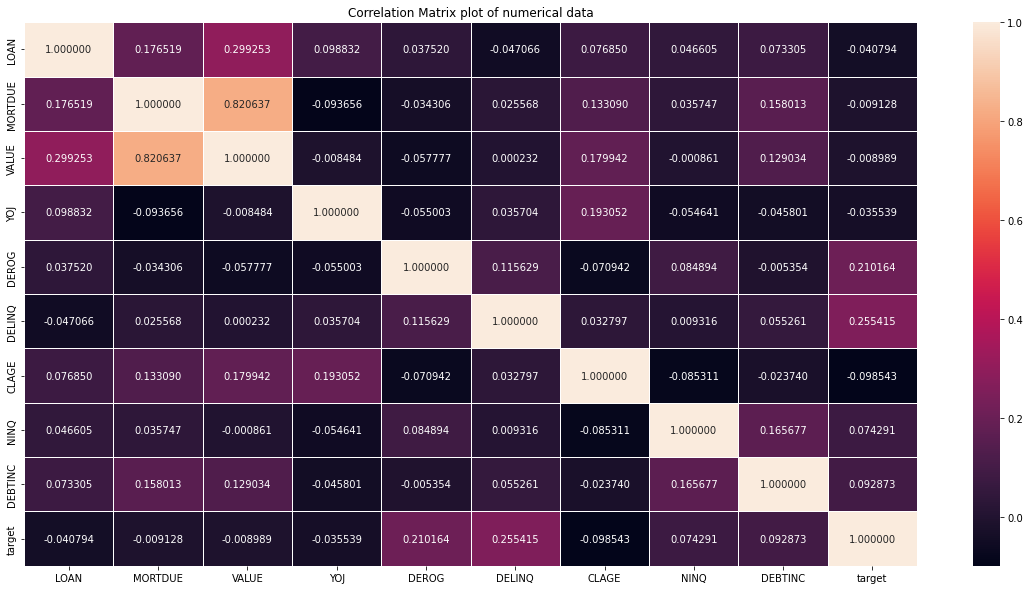

In [16]:
sns.heatmap(hmeq[all_num].corr(),annot=True,linewidth=.5,fmt='1f')
plt.title('Correlation Matrix plot of numerical data')
plt.show()

## 2.2 Categorical features clean and EDA

In [17]:
catvars = ['REASON', 'JOB']

In [18]:
#change data type
hmeq[catvars] = hmeq[catvars].astype('category') 

### Check missing value

In [19]:
print(hmeq[catvars].isnull().sum())

REASON    212
JOB       264
dtype: int64


In [20]:
# replace missing values with the mode
hmeq.REASON[hmeq.REASON.isnull() ] = hmeq.REASON.mode()[0] 
hmeq.JOB[hmeq.JOB.isnull() ] = hmeq.JOB.mode()[0] 

In [21]:
#check missing values
print(hmeq[catvars].isnull().sum())

REASON    0
JOB       0
dtype: int64


### Check categorical levels and disribution

In [22]:
for cat in catvars:
    print(hmeq[cat].value_counts())

DebtCon    3536
HomeImp    1474
Name: REASON, dtype: int64
Other      2215
ProfExe    1105
Office      848
Mgr         619
Self        144
Sales        79
Name: JOB, dtype: int64


# 3. Splitting data and Feature Engineering

## 3.1 Splitting data

In [23]:
y = hmeq['target']
X = hmeq.drop(['target'], axis=1)

X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=.2,shuffle=True, random_state= 1)

## 3.2 Feature engineer

### 3.2.1 Standardise numerical variables

In [24]:
standard = StandardScaler()

X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()

X_train_scaled[numvars] = standard.fit_transform(X_train_scaled[numvars])
X_val_scaled[numvars] = standard.transform(X_val_scaled[numvars])

X_val_scaled[numvars].head()

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,DEBTINC
5028,0.693783,0.203705,0.233341,0.147225,-0.240635,0.934679,-0.705033,-0.701383,-0.939327
2300,-0.446084,0.632513,0.202737,1.098239,1.399612,-0.343013,0.863783,-0.701383,0.277352
3221,-0.158873,0.412217,0.310346,0.690661,-0.240635,-0.343013,-0.551702,0.635347,0.180427
2217,-0.473010,-0.838658,-0.648477,-0.260353,-0.240635,-0.343013,-0.074733,-0.033018,0.238861
2033,-0.535837,0.548129,0.186097,0.690661,-0.240635,-0.343013,-0.035234,-0.033018,0.389174


### 3.2.2 Target encoding categorical variables

In [25]:
TE_encoder = TargetEncoder()
X_train_te = TE_encoder.fit_transform(X_train[catvars], y_train)
X_val_te = TE_encoder.transform(X_val[catvars])
print(X_train_te.head())

        REASON       JOB
1555  0.043724  0.056488
3187  0.043724  0.057613
4677  0.043724  0.056488
5048  0.043724  0.056488
5847  0.043724  0.030657


Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327


In [26]:
#CONCAT
X_train_final = pd.concat([X_train_scaled[numvars],X_train_te], axis=1)
X_val_final = pd.concat([X_val_scaled[numvars],X_val_te], axis=1)

# 4. Obtain resampling data

In [27]:
def resampling(ratio=1):
    X_data_list = []
    y_data_list = []
    for single_class in classes:
        if single_class == NearMiss:
            instance = single_class(sampling_strategy = ratio)
            X_data, y_data = instance.fit_resample(X_train_final, y_train.values.ravel())
            X_data_list.append(X_data)
            y_data_list.append(y_data)
            print('{} with {} completed'.format(single_class, ratio))
            print('Resampled dataset shape %s' % Counter(y_data))  
        else:
            instance = single_class(random_state=40, sampling_strategy = ratio)
            X_data, y_data = instance.fit_resample(X_train_final, y_train.values.ravel())
            X_data_list.append(X_data)
            y_data_list.append(y_data)
            print('{} with {} completed'.format(single_class, ratio))
            print('Resampled dataset shape %s' % Counter(y_data))       
    return X_data_list, y_data_list

In [28]:
classes = [RandomOverSampler, SMOTE, BorderlineSMOTE,
           RandomUnderSampler, NearMiss, InstanceHardnessThreshold,
           SMOTEENN, SMOTETomek]

#IR=1
X_data_list1, y_data_list1 = resampling(1)

print(len(X_data_list1),len(y_data_list1))

<class 'imblearn.over_sampling._random_over_sampler.RandomOverSampler'> with 1 completed
Resampled dataset shape Counter({0: 3814, 1: 3814})
<class 'imblearn.over_sampling._smote.base.SMOTE'> with 1 completed
Resampled dataset shape Counter({0: 3814, 1: 3814})
<class 'imblearn.over_sampling._smote.filter.BorderlineSMOTE'> with 1 completed
Resampled dataset shape Counter({0: 3814, 1: 3814})
<class 'imblearn.under_sampling._prototype_selection._random_under_sampler.RandomUnderSampler'> with 1 completed
Resampled dataset shape Counter({0: 194, 1: 194})
<class 'imblearn.under_sampling._prototype_selection._nearmiss.NearMiss'> with 1 completed
Resampled dataset shape Counter({0: 194, 1: 194})
<class 'imblearn.under_sampling._prototype_selection._instance_hardness_threshold.InstanceHardnessThreshold'> with 1 completed
Resampled dataset shape Counter({0: 1589, 1: 194})
<class 'imblearn.combine._smote_enn.SMOTEENN'> with 1 completed
Resampled dataset shape Counter({1: 3735, 0: 3604})
<class 'i

In [29]:
#IR=5
X_data_list2, y_data_list2 = resampling(0.2)

print(len(X_data_list2),len(y_data_list2))

<class 'imblearn.over_sampling._random_over_sampler.RandomOverSampler'> with 0.2 completed
Resampled dataset shape Counter({0: 3814, 1: 762})
<class 'imblearn.over_sampling._smote.base.SMOTE'> with 0.2 completed
Resampled dataset shape Counter({0: 3814, 1: 762})
<class 'imblearn.over_sampling._smote.filter.BorderlineSMOTE'> with 0.2 completed
Resampled dataset shape Counter({0: 3814, 1: 762})
<class 'imblearn.under_sampling._prototype_selection._random_under_sampler.RandomUnderSampler'> with 0.2 completed
Resampled dataset shape Counter({0: 970, 1: 194})
<class 'imblearn.under_sampling._prototype_selection._nearmiss.NearMiss'> with 0.2 completed
Resampled dataset shape Counter({0: 970, 1: 194})
<class 'imblearn.under_sampling._prototype_selection._instance_hardness_threshold.InstanceHardnessThreshold'> with 0.2 completed
Resampled dataset shape Counter({0: 1589, 1: 194})
<class 'imblearn.combine._smote_enn.SMOTEENN'> with 0.2 completed
Resampled dataset shape Counter({0: 3686, 1: 614})

In [30]:
#IR=10
X_data_list3, y_data_list3 = resampling(0.1)

print(len(X_data_list3),len(y_data_list3))

<class 'imblearn.over_sampling._random_over_sampler.RandomOverSampler'> with 0.1 completed
Resampled dataset shape Counter({0: 3814, 1: 381})
<class 'imblearn.over_sampling._smote.base.SMOTE'> with 0.1 completed
Resampled dataset shape Counter({0: 3814, 1: 381})
<class 'imblearn.over_sampling._smote.filter.BorderlineSMOTE'> with 0.1 completed
Resampled dataset shape Counter({0: 3814, 1: 381})
<class 'imblearn.under_sampling._prototype_selection._random_under_sampler.RandomUnderSampler'> with 0.1 completed
Resampled dataset shape Counter({0: 1940, 1: 194})
<class 'imblearn.under_sampling._prototype_selection._nearmiss.NearMiss'> with 0.1 completed
Resampled dataset shape Counter({0: 1940, 1: 194})
<class 'imblearn.under_sampling._prototype_selection._instance_hardness_threshold.InstanceHardnessThreshold'> with 0.1 completed
Resampled dataset shape Counter({0: 2390, 1: 194})
<class 'imblearn.combine._smote_enn.SMOTEENN'> with 0.1 completed
Resampled dataset shape Counter({0: 3703, 1: 164

In [31]:
#IR=15
X_data_list4, y_data_list4 = resampling(0.0667)

print(len(X_data_list4),len(y_data_list4))

<class 'imblearn.over_sampling._random_over_sampler.RandomOverSampler'> with 0.0667 completed
Resampled dataset shape Counter({0: 3814, 1: 254})
<class 'imblearn.over_sampling._smote.base.SMOTE'> with 0.0667 completed
Resampled dataset shape Counter({0: 3814, 1: 254})
<class 'imblearn.over_sampling._smote.filter.BorderlineSMOTE'> with 0.0667 completed
Resampled dataset shape Counter({0: 3814, 1: 254})
<class 'imblearn.under_sampling._prototype_selection._random_under_sampler.RandomUnderSampler'> with 0.0667 completed
Resampled dataset shape Counter({0: 2908, 1: 194})
<class 'imblearn.under_sampling._prototype_selection._nearmiss.NearMiss'> with 0.0667 completed
Resampled dataset shape Counter({0: 2908, 1: 194})
<class 'imblearn.under_sampling._prototype_selection._instance_hardness_threshold.InstanceHardnessThreshold'> with 0.0667 completed
Resampled dataset shape Counter({0: 2993, 1: 194})
<class 'imblearn.combine._smote_enn.SMOTEENN'> with 0.0667 completed
Resampled dataset shape Cou

# 5. Model training

## 5.1 Random forest

In [32]:
#grid search for hyper parameter tuning
rf = RandomForestClassifier(random_state=0)                       

param_grid = {'n_estimators': [25, 50, 100],
              'max_features': [2, 4, 8]
              }

gs_rf = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc', verbose=0)
gs_rf.fit(X_train_final, y_train.values.ravel())     

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_features': [2, 4, 8],
                         'n_estimators': [25, 50, 100]},
             scoring='roc_auc')

In [33]:
rf_tune = gs_rf.best_estimator_
print("Best CV AUC: %0.4f" % gs_rf.best_score_)
print("Optimal RF meta-parameters:")
print(gs_rf.best_params_)
print(rf_tune)

Best CV AUC: 0.9278
Optimal RF meta-parameters:
{'max_features': 2, 'n_estimators': 100}
RandomForestClassifier(max_features=2, random_state=0)


In [34]:
from function import evaluation
AUC_training,AUC_validation, precison, recall, Gmeans, F1, confusion_matrix = evaluation(y_train,X_train_final,y_val,X_val_final,rf_tune)
rf_eva = ['RF', AUC_training,AUC_validation, precison, recall, Gmeans, F1]
rf_eva

['RF', 1.0, 0.954, 1.0, 0.2, 0.447, 0.333]

## 5.2 neural network

In [35]:
# Define model
model = keras.Sequential([ 
    keras.Input(shape=(X_train_final.shape[1],)),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation = "sigmoid")
])

# Compile model
model.compile(optimizer = 'adam',## 5.2 neural network
    loss="binary_crossentropy",
    metrics = ["AUC"]
)
print(model.summary())

early_stopping_monitor = EarlyStopping(
    monitor='val_auc',
    min_delta=0,
    patience=5,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                192       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 209
Trainable params: 209
Non-trainable params: 0
_________________________________________________________________
None


2023-07-14 16:52:19.418799: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [36]:
# Fit the model
history = model.fit(X_train_final,
                    y_train,
                    epochs = 20,
                    batch_size = 2,
                    validation_data=(X_val_final, y_val),
                    callbacks=[early_stopping_monitor])

Epoch 1/20
2004/2004 [==============================] - 2s 917us/step - loss: 0.2353 - auc: 0.6184 - val_loss: 0.1663 - val_auc: 0.7267
Epoch 2/20
2004/2004 [==============================] - 2s 854us/step - loss: 0.1677 - auc: 0.7510 - val_loss: 0.1588 - val_auc: 0.7587
Epoch 3/20
2004/2004 [==============================] - 2s 949us/step - loss: 0.1603 - auc: 0.7734 - val_loss: 0.1561 - val_auc: 0.7586
Epoch 4/20
2004/2004 [==============================] - 2s 871us/step - loss: 0.1545 - auc: 0.7866 - val_loss: 0.1552 - val_auc: 0.7689
Epoch 5/20
2004/2004 [==============================] - 2s 858us/step - loss: 0.1504 - auc: 0.8009 - val_loss: 0.1538 - val_auc: 0.7681
Epoch 6/20
2004/2004 [==============================] - 2s 865us/step - loss: 0.1483 - auc: 0.8074 - val_loss: 0.1539 - val_auc: 0.7644
Epoch 7/20
2004/2004 [==============================] - 2s 861us/step - loss: 0.1462 - auc: 0.8078 - val_loss: 0.1513 - val_auc: 0.7682
Epoch 8/20
2004/2004 [==========================

In [37]:
from function import evaluation_nn
AUC_training,AUC_validation, precison, recall, Gmeans, F1, confusion_matrix = evaluation_nn(y_train,X_train_final,y_val,X_val_final,model)
nn_eva = ['NN', AUC_training,AUC_validation, precison, recall, Gmeans, F1]
nn_eva

['NN', 0.83, 0.776, 1.0, 0.156, 0.394, 0.269]

## 5.3 Logit

### 5.3.1 Train logit

In [38]:
logit = LogisticRegressionCV(cv=5, random_state=0, max_iter=2000).fit(X_train_final,y_train.values.ravel())

In [39]:
from function import evaluation
AUC_training,AUC_validation, precison, recall, Gmeans, F1, confusion_matrix = evaluation(y_train,X_train_final,y_val,X_val_final,logit)
logit_eva = ['logit', AUC_training,AUC_validation, precison, recall, Gmeans, F1]
logit_eva

['logit', 0.787, 0.754, 0.833, 0.111, 0.333, 0.196]

### 5.3.2 Applying resampling methods on logit

In [40]:
def logit_resampling(X_data_list, y_data_list):
    AUC_training_list = []
    AUC_validation_list = []
    precision_list = []
    recall_list = []
    Gmeans_list = []
    F1_list = []
    confusion_matrix_list = []
    for X_data, y_data in zip(X_data_list, y_data_list):
        instance_lr = logit.fit(X_data, y_data)
        AUC_training,AUC_validation, precison, recall, Gmeans, F1, confusion_matrix = evaluation(y_data,X_data,y_val,X_val_final,instance_lr)
        AUC_training_list.append(AUC_training)
        AUC_validation_list.append(AUC_validation)
        precision_list.append(precison)
        recall_list.append(recall)
        Gmeans_list.append(Gmeans)
        F1_list.append(F1)
        confusion_matrix_list.append(confusion_matrix)
    print("AUC validation:{}".format(AUC_validation_list))
    return AUC_training_list, AUC_validation_list, precision_list, recall_list, Gmeans_list, F1_list, confusion_matrix_list

In [41]:
#IR =1
AUC_training_list, AUC_validation_list, precision_list, recall_list, Gmeans_list, F1_list, confusion_matrix_list = logit_resampling(X_data_list1, y_data_list1)

approaches = ['RandomOverSampler', 'SMOTE','BorderlineSMOTE',
             'RandomUnderSampler', 'NearMiss', 'InstanceHardnessThreshold',
             'SMOTEENN', 'SMOTETomek']

dic = {'Approaches': approaches, 'AUC_training': AUC_training_list,
     'AUC_validation': AUC_validation_list ,'precison': precision_list, 
     'recall': recall_list, 'Gmeans' : Gmeans_list, 'F1': F1_list}
#turn into dataframe
dflog = pd.DataFrame(dic)
dflog.loc[len(dflog)] = logit_eva
dflog

AUC validation:[0.762, 0.751, 0.756, 0.752, 0.708, 0.758, 0.752, 0.752]


,Approaches,AUC_training,AUC_validation,precison,recall,Gmeans,F1
0,RandomOverSampler,0.803,0.762,0.126,0.622,0.704,0.210
1,SMOTE,0.807,0.751,0.106,0.578,0.668,0.179
2,BorderlineSMOTE,0.857,0.756,0.119,0.578,0.679,0.197
3,RandomUnderSampler,0.809,0.752,0.110,0.600,0.680,0.186
4,NearMiss,0.888,0.708,0.066,0.756,0.612,0.121
5,InstanceHardnessThreshold,0.866,0.758,0.215,0.311,0.543,0.255
6,SMOTEENN,0.819,0.752,0.102,0.578,0.663,0.173
7,SMOTETomek,0.807,0.752,0.106,0.578,0.668,0.179
8,logit,0.787,0.754,0.833,0.111,0.333,0.196


In [42]:
# IR = 5
AUC_training_list, AUC_validation_list, precision_list, recall_list, Gmeans_list, F1_list, confusion_matrix_list = logit_resampling(X_data_list2, y_data_list2)

approaches = ['RandomOverSampler', 'SMOTE','BorderlineSMOTE',
             'RandomUnderSampler', 'NearMiss', 'InstanceHardnessThreshold',
             'SMOTEENN', 'SMOTETomek']

dic = {'Approaches': approaches, 'AUC_training': AUC_training_list,
     'AUC_validation': AUC_validation_list ,'precison': precision_list, 
     'recall': recall_list, 'Gmeans' : Gmeans_list, 'F1': F1_list}
#turn into dataframe
dflog2 = pd.DataFrame(dic)
dflog2.loc[len(dflog2)] = logit_eva
dflog2

AUC validation:[0.769, 0.747, 0.744, 0.753, 0.695, 0.758, 0.756, 0.747]


,Approaches,AUC_training,AUC_validation,precison,recall,Gmeans,F1
0,RandomOverSampler,0.802,0.769,0.294,0.222,0.465,0.253
1,SMOTE,0.799,0.747,0.333,0.200,0.443,0.250
2,BorderlineSMOTE,0.824,0.744,0.379,0.244,0.490,0.297
3,RandomUnderSampler,0.800,0.753,0.324,0.244,0.488,0.278
4,NearMiss,0.843,0.695,0.105,0.489,0.627,0.173
5,InstanceHardnessThreshold,0.866,0.758,0.215,0.311,0.543,0.255
6,SMOTEENN,0.861,0.756,0.367,0.244,0.489,0.293
7,SMOTETomek,0.800,0.747,0.333,0.200,0.443,0.250
8,logit,0.787,0.754,0.833,0.111,0.333,0.196


In [43]:
# IR = 10
AUC_training_list, AUC_validation_list, precision_list, recall_list, Gmeans_list, F1_list, confusion_matrix_list = logit_resampling(X_data_list3, y_data_list3)

approaches = ['RandomOverSampler', 'SMOTE','BorderlineSMOTE',
             'RandomUnderSampler', 'NearMiss', 'InstanceHardnessThreshold',
             'SMOTEENN', 'SMOTETomek']

dic = {'Approaches': approaches, 'AUC_training': AUC_training_list,
     'AUC_validation': AUC_validation_list ,'precison': precision_list, 
     'recall': recall_list, 'Gmeans' : Gmeans_list, 'F1': F1_list}
#turn into dataframe
dflog3 = pd.DataFrame(dic)
dflog3.loc[len(dflog3)] = logit_eva
dflog3

AUC validation:[0.757, 0.755, 0.743, 0.756, 0.709, 0.762, 0.764, 0.751]


,Approaches,AUC_training,AUC_validation,precison,recall,Gmeans,F1
0,RandomOverSampler,0.795,0.757,0.500,0.156,0.393,0.237
1,SMOTE,0.788,0.755,0.429,0.133,0.364,0.203
2,BorderlineSMOTE,0.808,0.743,0.467,0.156,0.393,0.233
3,RandomUnderSampler,0.798,0.756,0.467,0.156,0.393,0.233
4,NearMiss,0.792,0.709,0.188,0.289,0.522,0.228
5,InstanceHardnessThreshold,0.848,0.762,0.324,0.267,0.510,0.293
6,SMOTEENN,0.908,0.764,0.800,0.089,0.298,0.160
7,SMOTETomek,0.784,0.751,0.429,0.133,0.364,0.203
8,logit,0.787,0.754,0.833,0.111,0.333,0.196


In [44]:
#IR = 15
AUC_training_list, AUC_validation_list, precision_list, recall_list, Gmeans_list, F1_list, confusion_matrix_list = logit_resampling(X_data_list4, y_data_list4)

approaches = ['RandomOverSampler', 'SMOTE','BorderlineSMOTE',
             'RandomUnderSampler', 'NearMiss', 'InstanceHardnessThreshold',
             'SMOTEENN', 'SMOTETomek']

dic = {'Approaches': approaches, 'AUC_training': AUC_training_list,
     'AUC_validation': AUC_validation_list ,'precison': precision_list, 
     'recall': recall_list, 'Gmeans' : Gmeans_list, 'F1': F1_list}
#turn into dataframe
dflog4 = pd.DataFrame(dic)
dflog4.loc[len(dflog4)] = logit_eva
dflog4

AUC validation:[0.76, 0.775, 0.751, 0.748, 0.745, 0.757, 0.775, 0.761]


,Approaches,AUC_training,AUC_validation,precison,recall,Gmeans,F1
0,RandomOverSampler,0.791,0.760,0.714,0.111,0.333,0.192
1,SMOTE,0.783,0.775,1.000,0.067,0.258,0.125
2,BorderlineSMOTE,0.805,0.751,0.600,0.133,0.364,0.218
3,RandomUnderSampler,0.780,0.748,0.714,0.111,0.333,0.192
4,NearMiss,0.769,0.745,0.538,0.156,0.393,0.241
5,InstanceHardnessThreshold,0.829,0.757,0.348,0.178,0.418,0.235
6,SMOTEENN,0.967,0.775,1.000,0.067,0.258,0.125
7,SMOTETomek,0.805,0.761,0.750,0.133,0.365,0.226
8,logit,0.787,0.754,0.833,0.111,0.333,0.196


### Aggregate and output result

In [45]:
#aggregate AUC validation
dflogit = pd.concat([dflog4.iloc[:,2],dflog3.iloc[:,2],dflog2.iloc[:,2],dflog.iloc[:,2]],axis=1)
dflogit.columns = ['1:15', '1:10', '1:5', '1:1']
dflogit.index = dflog4.iloc[:,0]
dflogit

,1:15,1:10,1:5,1:1
Approaches,,,,
RandomOverSampler,0.760,0.757,0.769,0.762
SMOTE,0.775,0.755,0.747,0.751
BorderlineSMOTE,0.751,0.743,0.744,0.756
RandomUnderSampler,0.748,0.756,0.753,0.752
NearMiss,0.745,0.709,0.695,0.708
InstanceHardnessThreshold,0.757,0.762,0.758,0.758
SMOTEENN,0.775,0.764,0.756,0.752
SMOTETomek,0.761,0.751,0.747,0.752
logit,0.754,0.754,0.754,0.754


In [46]:
import os
path = './result'
file_path = path + '/hmeq_logit_auc.csv'
os.makedirs(path, exist_ok=True)
dflogit.to_csv(file_path, index =True, encoding = 'utf-8-sig') 

In [47]:
#aggregate gmeans 
logit_gmeans = pd.concat([dflog4.iloc[:,5],dflog3.iloc[:,5],dflog2.iloc[:,5],dflog.iloc[:,5]],axis=1)
logit_gmeans.columns = ['1:15', '1:10', '1:5', '1:1']
logit_gmeans.index = dflog4.iloc[:,0]
logit_gmeans

,1:15,1:10,1:5,1:1
Approaches,,,,
RandomOverSampler,0.333,0.393,0.465,0.704
SMOTE,0.258,0.364,0.443,0.668
BorderlineSMOTE,0.364,0.393,0.490,0.679
RandomUnderSampler,0.333,0.393,0.488,0.680
NearMiss,0.393,0.522,0.627,0.612
InstanceHardnessThreshold,0.418,0.510,0.543,0.543
SMOTEENN,0.258,0.298,0.489,0.663
SMOTETomek,0.365,0.364,0.443,0.668
logit,0.333,0.333,0.333,0.333


In [48]:
logit_gmeans.to_csv(path + '/hmeq_logit_gmeans.csv', index =True, encoding = 'utf-8-sig') 

In [49]:
#aggregate fmeasure
logit_fmeasure = pd.concat([dflog4.iloc[:,6],dflog3.iloc[:,6],dflog2.iloc[:,6],dflog.iloc[:,6]],axis=1)
logit_fmeasure.columns = ['1:15', '1:10', '1:5', '1:1']
logit_fmeasure.index = dflog4.iloc[:,0]
logit_fmeasure

,1:15,1:10,1:5,1:1
Approaches,,,,
RandomOverSampler,0.192,0.237,0.253,0.210
SMOTE,0.125,0.203,0.250,0.179
BorderlineSMOTE,0.218,0.233,0.297,0.197
RandomUnderSampler,0.192,0.233,0.278,0.186
NearMiss,0.241,0.228,0.173,0.121
InstanceHardnessThreshold,0.235,0.293,0.255,0.255
SMOTEENN,0.125,0.160,0.293,0.173
SMOTETomek,0.226,0.203,0.250,0.179
logit,0.196,0.196,0.196,0.196


In [50]:
logit_fmeasure.to_csv(path + '/hmeq_logit_fmeasure.csv', index =True, encoding = 'utf-8-sig') 

## 5.4 XGBoost

### 5.4.1 training XGBoost

In [51]:
#perform hyper parameter grid search
xgb_param_grid = {
    'colsample_bytree': np.linspace(0.1, 0.8, 3), # Subsample ratio of columns when constructing each tree
    'n_estimators': [50,75,100],  # Number of gradient boosted trees
    'max_depth': [3, 5, 8],   # max depth of decision trees
    'learning_rate': np.linspace(0.01, 0.1, 3), #Boosting learning rate
    'subsample': np.linspace(0.5, 0.8, 3)}  # Subsample ratio of the training instance

gs_xgb = GridSearchCV(estimator=XGBClassifier(use_label_encoder=False, eval_metric ='auc'), 
                      param_grid=xgb_param_grid, scoring='roc_auc', cv=5, verbose=0)

gs_xgb.fit(X_train_final, y_train.values.ravel())
xgb_tune = gs_xgb.best_estimator_
print("Best CV AUC: %0.4f" % gs_xgb.best_score_)
print("Optimal XGB meta-parameters:")
print(gs_xgb.best_params_)
print(xgb_tune)

Best CV AUC: 0.9144
Optimal XGB meta-parameters:
{'colsample_bytree': 0.45000000000000007, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 75, 'subsample': 0.65}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.45000000000000007,
              enable_categorical=False, eval_metric='auc', gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=75, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.65, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)


In [52]:
#run this to skip xgb tuning
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.45000000000000007,
              enable_categorical=False, eval_metric='auc', gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=75, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.65, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

xgb_tune.fit(X_train_final, y_train.values.ravel())

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.45000000000000007,
              enable_categorical=False, eval_metric='auc', gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=75, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.65, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [53]:
AUC_training,AUC_validation, precison, recall, Gmeans, F1, confusion_matrix = evaluation(y_train,X_train_final,y_val,X_val_final,xgb_tune)
xgb_eva=['xgb', AUC_training,AUC_validation, precison, recall, Gmeans, F1]
xgb_eva

['xgb', 0.997, 0.934, 1.0, 0.2, 0.447, 0.333]

### 5.4.2 Apply resampling methods on  XGBoost

In [54]:
def xgb_resampling(X_data_list, y_data_list):
    AUC_training_list = []
    AUC_validation_list = []
    precision_list = []
    recall_list = []
    Gmeans_list = []
    F1_list = []
    confusion_matrix_list = []
    for X_data, y_data in zip(X_data_list, y_data_list):
        instance_xgb = xgb_tune.fit(X_data, y_data,eval_set=[(X_val_final, y_val)], early_stopping_rounds= 50)
        AUC_training,AUC_validation, precison, recall, Gmeans, F1, confusion_matrix = evaluation(y_data,X_data,y_val,X_val_final,xgb_tune)
        AUC_training_list.append(AUC_training)
        AUC_validation_list.append(AUC_validation)
        precision_list.append(precison)
        recall_list.append(recall)
        Gmeans_list.append(Gmeans)
        F1_list.append(F1)
        confusion_matrix_list.append(confusion_matrix)
       
    print("AUC validation:{}".format(AUC_validation_list))
    return AUC_training_list, AUC_validation_list, precision_list, recall_list, Gmeans_list, F1_list, confusion_matrix_list

In [ ]:
#IR =1
AUC_training_list, AUC_validation_list, precision_list, recall_list, Gmeans_list, F1_list, confusion_matrix_list = xgb_resampling(X_data_list1, y_data_list1)

approaches = ['RandomOverSampler', 'SMOTE','BorderlineSMOTE',
             'RandomUnderSampler', 'NearMiss', 'InstanceHardnessThreshold',
             'SMOTEENN', 'SMOTETomek']

dic = {'Approaches': approaches, 'AUC_training': AUC_training_list,
     'AUC_validation': AUC_validation_list ,'precison': precision_list, 
     'recall': recall_list, 'Gmeans' : Gmeans_list, 'F1': F1_list}

dfxgb = pd.DataFrame(dic)
dfxgb.loc[len(dfxgb)] = xgb_eva
dfxgb

In [ ]:
#IR=5
AUC_training_list, AUC_validation_list, precision_list, recall_list, Gmeans_list, F1_list, confusion_matrix_list = xgb_resampling(X_data_list2, y_data_list2)

approaches = ['RandomOverSampler', 'SMOTE','BorderlineSMOTE',
             'RandomUnderSampler', 'NearMiss', 'InstanceHardnessThreshold',
             'SMOTEENN', 'SMOTETomek']

dic = {'Approaches': approaches, 'AUC_training': AUC_training_list,
     'AUC_validation': AUC_validation_list ,'precison': precision_list, 
     'recall': recall_list, 'Gmeans' : Gmeans_list, 'F1': F1_list}

dfxgb2 = pd.DataFrame(dic)
dfxgb2.loc[len(dfxgb2)] = xgb_eva
dfxgb2

In [ ]:
#IR=10
AUC_training_list, AUC_validation_list, precision_list, recall_list, Gmeans_list, F1_list, confusion_matrix_list = xgb_resampling(X_data_list3, y_data_list3)

approaches = ['RandomOverSampler', 'SMOTE','BorderlineSMOTE',
             'RandomUnderSampler', 'NearMiss', 'InstanceHardnessThreshold',
             'SMOTEENN', 'SMOTETomek']

dic = {'Approaches': approaches, 'AUC_training': AUC_training_list,
     'AUC_validation': AUC_validation_list ,'precison': precision_list, 
     'recall': recall_list, 'Gmeans' : Gmeans_list, 'F1': F1_list}

dfxgb3 = pd.DataFrame(dic)
dfxgb3.loc[len(dfxgb3)] = xgb_eva
dfxgb3

In [ ]:
#IR=15
AUC_training_list, AUC_validation_list, precision_list, recall_list, Gmeans_list, F1_list, confusion_matrix_list = xgb_resampling(X_data_list4, y_data_list4)

approaches = ['RandomOverSampler', 'SMOTE','BorderlineSMOTE',
             'RandomUnderSampler', 'NearMiss', 'InstanceHardnessThreshold',
             'SMOTEENN', 'SMOTETomek']

dic = {'Approaches': approaches, 'AUC_training': AUC_training_list,
     'AUC_validation': AUC_validation_list ,'precison': precision_list, 
     'recall': recall_list, 'Gmeans' : Gmeans_list, 'F1': F1_list}
#turn into dataframe
dfxgb4 = pd.DataFrame(dic)
dfxgb4.loc[len(dfxgb4)] = xgb_eva
dfxgb4

### Aggregate and output results

In [59]:
#aggregate AUC validation
dfxgboost = pd.concat([dfxgb4.iloc[:,2],dfxgb3.iloc[:,2],dfxgb2.iloc[:,2],dfxgb.iloc[:,2]],axis=1)
dfxgboost.columns = ['1:15', '1:10', '1:5', '1:1']
dfxgboost.index = dfxgb4.iloc[:,0]
dfxgboost

,1:15,1:10,1:5,1:1
Approaches,,,,
RandomOverSampler,0.916,0.940,0.939,0.925
SMOTE,0.920,0.927,0.931,0.931
BorderlineSMOTE,0.923,0.917,0.938,0.932
RandomUnderSampler,0.946,0.938,0.919,0.911
NearMiss,0.924,0.871,0.809,0.675
InstanceHardnessThreshold,0.926,0.925,0.921,0.921
SMOTEENN,0.905,0.898,0.923,0.912
SMOTETomek,0.932,0.937,0.916,0.908
xgb,0.934,0.934,0.934,0.934


In [60]:
dfxgboost.to_csv(path + '/hmeq_xgb_auc.csv', index = True, encoding = 'utf-8-sig') 

In [61]:
#aggregate gmeans
xgb_gmeans = pd.concat([dfxgb4.iloc[:,5],dfxgb3.iloc[:,5],dfxgb2.iloc[:,5],dfxgb.iloc[:,5]],axis=1)
xgb_gmeans.columns = ['1:15', '1:10', '1:5', '1:1']
xgb_gmeans.index = dfxgb4.iloc[:,0]
xgb_gmeans

,1:15,1:10,1:5,1:1
Approaches,,,,
RandomOverSampler,0.471,0.516,0.593,0.708
SMOTE,0.421,0.394,0.516,0.515
BorderlineSMOTE,0.365,0.471,0.446,0.515
RandomUnderSampler,0.470,0.612,0.752,0.831
NearMiss,0.470,0.667,0.713,0.542
InstanceHardnessThreshold,0.768,0.829,0.840,0.840
SMOTEENN,0.211,0.258,0.258,0.574
SMOTETomek,0.447,0.471,0.447,0.594
xgb,0.447,0.447,0.447,0.447


In [62]:
xgb_gmeans.to_csv(path + '/hmeq_xgb_gmeans.csv', index = True, encoding = 'utf-8-sig') 

In [63]:
#aggregate fmeasure
xgb_fmeasure = pd.concat([dfxgb4.iloc[:,6],dfxgb3.iloc[:,6],dfxgb2.iloc[:,6],dfxgb.iloc[:,6]],axis=1)
xgb_fmeasure.columns = ['1:15', '1:10', '1:5', '1:1']
xgb_fmeasure.index = dfxgb4.iloc[:,0]
xgb_fmeasure

,1:15,1:10,1:5,1:1
Approaches,,,,
RandomOverSampler,0.351,0.400,0.451,0.529
SMOTE,0.296,0.264,0.400,0.393
BorderlineSMOTE,0.235,0.351,0.300,0.387
RandomUnderSampler,0.339,0.479,0.565,0.314
NearMiss,0.333,0.288,0.198,0.105
InstanceHardnessThreshold,0.455,0.475,0.414,0.414
SMOTEENN,0.085,0.125,0.125,0.417
SMOTETomek,0.333,0.345,0.321,0.478
xgb,0.333,0.333,0.333,0.333


In [64]:
xgb_fmeasure.to_csv(path + '/hmeq_xgb_fmeasure.csv', index = True, encoding = 'utf-8-sig') 

In [65]:
#aggregate the evaluation results for four models
models = [logit_eva[0], rf_eva[0],xgb_eva[0],nn_eva[0]]
AUC_val = [logit_eva[2], rf_eva[2],xgb_eva[2],nn_eva[2]]
Gmeans = [logit_eva[5], rf_eva[5],xgb_eva[5],nn_eva[5]]
Fmeasure = [logit_eva[6], rf_eva[6],xgb_eva[6],nn_eva[6]]
dic ={'Model': models, 'AUC_validation':AUC_val, 'G-means':Gmeans, 'F1-score':Fmeasure}
models_eva = pd.DataFrame(dic)
models_eva

,Model,AUC_validation,G-means,F1-score
0,logit,0.754,0.333,0.196
1,RF,0.954,0.447,0.333
2,xgb,0.934,0.447,0.333
3,NN,0.776,0.394,0.269


In [66]:
models_eva.to_csv(path + '/hmeq_models.csv', index = True, encoding = 'utf-8-sig') 

# 6. XAI

## 6.1 SHAP fearure importance

### 6.1.1 Calculate SHAP feature importance

In [67]:
instance =xgb_tune.fit(X_train_final, y_train.values.ravel())
explainer_xgb = shap.TreeExplainer(xgb_tune, data=X_train_final, 
                                   feature_perturbation='interventional', model_output='probability')
shap_values_xgb = explainer_xgb.shap_values(X_train_final)
print(shap_values_xgb.shape)

result__ = pd.DataFrame(shap_values_xgb, columns = X_train_final.columns)

#for global importance, we average the absolute Shapley values per feature across the data: 
vals__ = np.abs(result__.values).mean(0).round(3)
shap_importance = pd.DataFrame(list(zip(X_train_final.columns, vals__)),
                                  columns=['feature','xgb'])
print(shap_importance.head())

 99%|===================| 3970/4008 [00:12<00:00]        

(4008, 11)
   feature    xgb
0     LOAN  0.007
1  MORTDUE  0.006
2    VALUE  0.007
3      YOJ  0.006
4    DEROG  0.007


In [68]:
def shap_generator(X_data_list, y_data_list,model):
    vals_list = []
    for X_data, y_data in zip(X_data_list, y_data_list):
        instance_xgb = model.fit(X_data, y_data,
                                 eval_set=[(X_val_final, y_val)], early_stopping_rounds= 50)
        explainer_instance = shap.TreeExplainer(model, data=X_data, 
                                                feature_perturbation='interventional', model_output='probability')
        shap_values_instance = explainer_instance.shap_values(X_data)
        result = pd.DataFrame(shap_values_instance, columns = X_data.columns)
        vals = np.abs(result.values).mean(0).round(3)
        
        vals_list.append(vals)
    return vals_list

In [69]:
#extract RUS,IHT resampled data sets
#order: rus1,rus5,rus10,rus15,iht1,iht5,iht10,iht15
RE_Xlist= [X_data_list1[3],X_data_list2[3],X_data_list3[3], X_data_list4[3],
           X_data_list1[4],X_data_list2[4], X_data_list3[4], X_data_list4[4]]
RE_ylist =[y_data_list1[3],y_data_list2[3],y_data_list3[3], y_data_list4[3],
           y_data_list1[4],y_data_list2[4], y_data_list3[4], y_data_list4[4]]

In [ ]:
shap_list = shap_generator(RE_Xlist, RE_ylist,xgb_tune)

In [71]:
#rus1,rus5,rus10,rus15,iht1,iht5,iht10,iht15
shap_importance['rus1'] = shap_list[0]
shap_importance['rus5'] = shap_list[1]
shap_importance['rus10'] = shap_list[2]
shap_importance['rus15'] = shap_list[3]
shap_importance['iht1'] = shap_list[4]
shap_importance['iht5'] = shap_list[5]
shap_importance['iht10'] = shap_list[6]
shap_importance['iht15'] = shap_list[7]

shap_importance

,feature,xgb,rus1,rus5,rus10,rus15,iht1,iht5,iht10,iht15
0,LOAN,0.007,0.042,0.023,0.018,0.009,0.015,0.018,0.019,0.007
1,MORTDUE,0.006,0.031,0.017,0.011,0.008,0.031,0.017,0.016,0.007
2,VALUE,0.007,0.039,0.018,0.014,0.007,0.009,0.027,0.015,0.006
3,YOJ,0.006,0.027,0.015,0.009,0.006,0.005,0.021,0.008,0.004
4,DEROG,0.007,0.025,0.014,0.013,0.004,0.007,0.026,0.023,0.005
5,DELINQ,0.023,0.077,0.031,0.025,0.018,0.068,0.037,0.026,0.019
6,CLAGE,0.015,0.056,0.040,0.025,0.015,0.018,0.019,0.019,0.013
7,NINQ,0.005,0.017,0.010,0.007,0.006,0.009,0.018,0.008,0.006
8,DEBTINC,0.040,0.197,0.082,0.080,0.037,0.055,0.060,0.067,0.028
9,REASON,0.003,0.005,0.004,0.003,0.001,0.000,0.002,0.002,0.001


In [72]:
shap_importance.to_csv(path + '/shap_importance.csv', index = True, encoding = 'utf-8-sig') 

### 6.2.2  SHAP rank correlation

In [73]:
rank_shap = shap_importance.corr(method = 'spearman').round(3)
print(rank_shap)

         xgb   rus1   rus5  rus10  rus15   iht1   iht5  iht10  iht15
xgb    1.000  0.940  0.931  0.984  0.868  0.788  0.848  0.931  0.845
rus1   0.940  1.000  0.991  0.961  0.952  0.852  0.720  0.831  0.892
rus5   0.931  0.991  1.000  0.961  0.943  0.825  0.683  0.808  0.883
rus10  0.984  0.961  0.961  1.000  0.922  0.836  0.781  0.913  0.899
rus15  0.868  0.952  0.943  0.922  1.000  0.943  0.646  0.805  0.968
iht1   0.788  0.852  0.825  0.836  0.943  1.000  0.573  0.812  0.972
iht5   0.848  0.720  0.683  0.781  0.646  0.573  1.000  0.769  0.596
iht10  0.931  0.831  0.808  0.913  0.805  0.812  0.769  1.000  0.839
iht15  0.845  0.892  0.883  0.899  0.968  0.972  0.596  0.839  1.000


In [74]:
rank_shap.to_csv(path + '/rank_shap.csv', index = True, encoding = 'utf-8-sig') 

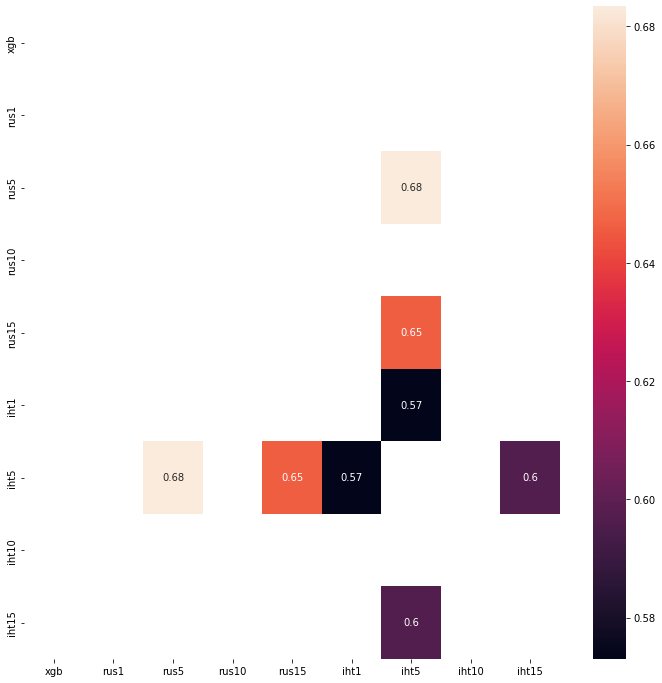

In [75]:
plt.rcParams['figure.figsize'] = (12 , 12)
snsfilter = sns.heatmap(shap_importance.corr(method = 'spearman')[(shap_importance.corr(method = 'spearman') <= 0.692)],
            annot=True);

### 6.2.3  SHAP feature importance visualisation

In [76]:
#select top 10 features for original xgb
shap_top10 = shap_importance.sort_values(['xgb'], ascending=[False])
shap_top10 = shap_top10.head(10)
shap_top10

,feature,xgb,rus1,rus5,rus10,rus15,iht1,iht5,iht10,iht15
8,DEBTINC,0.040,0.197,0.082,0.080,0.037,0.055,0.060,0.067,0.028
5,DELINQ,0.023,0.077,0.031,0.025,0.018,0.068,0.037,0.026,0.019
6,CLAGE,0.015,0.056,0.040,0.025,0.015,0.018,0.019,0.019,0.013
0,LOAN,0.007,0.042,0.023,0.018,0.009,0.015,0.018,0.019,0.007
2,VALUE,0.007,0.039,0.018,0.014,0.007,0.009,0.027,0.015,0.006
4,DEROG,0.007,0.025,0.014,0.013,0.004,0.007,0.026,0.023,0.005
1,MORTDUE,0.006,0.031,0.017,0.011,0.008,0.031,0.017,0.016,0.007
3,YOJ,0.006,0.027,0.015,0.009,0.006,0.005,0.021,0.008,0.004
7,NINQ,0.005,0.017,0.010,0.007,0.006,0.009,0.018,0.008,0.006
10,JOB,0.005,0.020,0.013,0.006,0.003,0.003,0.012,0.007,0.004


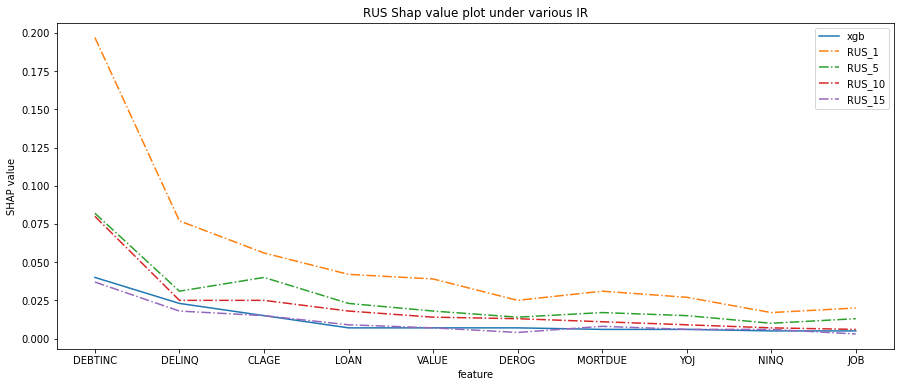

In [77]:
#1.aggeragate by approaches
#rus under different IR
x = shap_top10['feature'].tolist()
xgb_base =shap_top10['xgb'].tolist()
rus_1 =shap_top10['rus1'].tolist()
rus_5 =shap_top10['rus5'].tolist()
rus_10 =shap_top10['rus10'].tolist()
rus_15 =shap_top10['rus15'].tolist()

#plot
plt.rcParams['figure.figsize'] = (15 , 6)

plt.plot(x, xgb_base, label ='xgb')
plt.plot(x, rus_1, '-.', label ='RUS_1')
plt.plot(x, rus_5, '-.', label ='RUS_5')
plt.plot(x, rus_10, '-.', label ='RUS_10')
plt.plot(x, rus_15, '-.', label ='RUS_15')

plt.xlabel("feature")
plt.ylabel("SHAP value")
plt.legend()
plt.title('RUS Shap value plot under various IR')
plt.show()

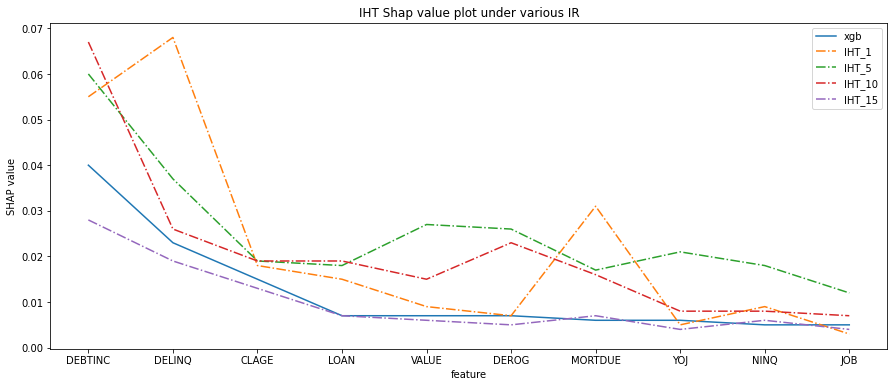

In [78]:
#iht under different IR
x = shap_top10['feature'].tolist()
xgb_base =shap_top10['xgb'].tolist()
iht_1 =shap_top10['iht1'].tolist()
iht_5 =shap_top10['iht5'].tolist()
iht_10 =shap_top10['iht10'].tolist()
iht_15 =shap_top10['iht15'].tolist()

#plot
plt.rcParams['figure.figsize'] = (15 , 6)

plt.plot(x, xgb_base, label ='xgb')
plt.plot(x, iht_1, '-.', label ='IHT_1')
plt.plot(x, iht_5, '-.', label ='IHT_5')
plt.plot(x, iht_10, '-.', label ='IHT_10')
plt.plot(x, iht_15, '-.', label ='IHT_15')

plt.xlabel("feature")
plt.ylabel("SHAP value")
plt.legend()
plt.title('IHT Shap value plot under various IR')
plt.show()

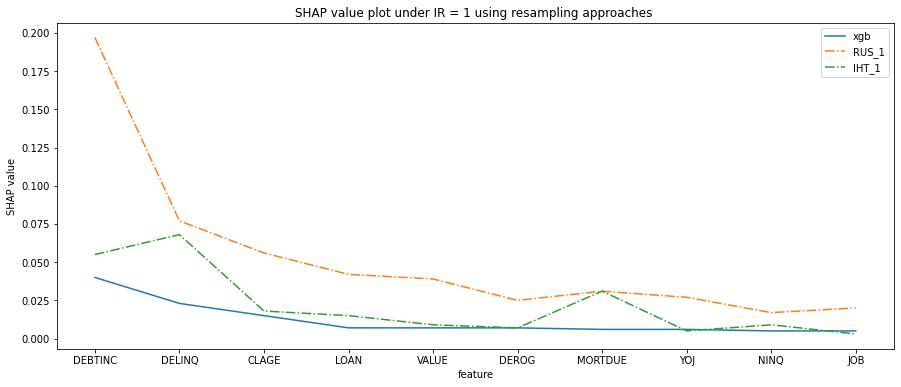

In [79]:
#aggeragate by ratio
#IR=1 under various approaches
x = shap_top10['feature'].tolist()
xgb_base =shap_top10['xgb'].tolist()

RUS_1 =shap_top10['rus1'].tolist()
IHT_1 =shap_top10['iht1'].tolist()

#plot
plt.rcParams['figure.figsize'] = (15 , 6)

plt.plot(x, xgb_base, label ='xgb')
plt.plot(x, RUS_1, '-.', label ='RUS_1')
plt.plot(x, IHT_1, '-.', label ='IHT_1')


plt.xlabel("feature")
plt.ylabel("SHAP value")
plt.legend()
plt.title('SHAP value plot under IR = 1 using resampling approaches ')
plt.show()

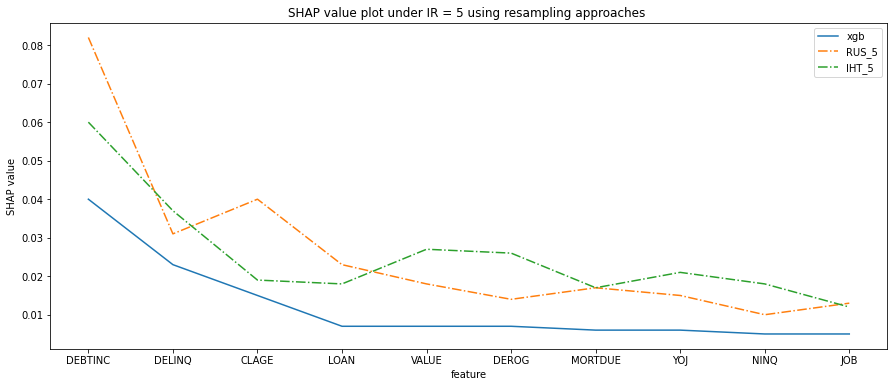

In [80]:
#IR=5 under various approaches
x = shap_top10['feature'].tolist()
xgb_base =shap_top10['xgb'].tolist()

RUS_5 =shap_top10['rus5'].tolist()
IHT_5 =shap_top10['iht5'].tolist()

#plot
plt.rcParams['figure.figsize'] = (15 , 6)

plt.plot(x, xgb_base, label ='xgb')
plt.plot(x, RUS_5, '-.', label ='RUS_5')
plt.plot(x, IHT_5, '-.', label ='IHT_5')


plt.xlabel("feature")
plt.ylabel("SHAP value")
plt.legend()
plt.title('SHAP value plot under IR = 5 using resampling approaches ')
plt.show()

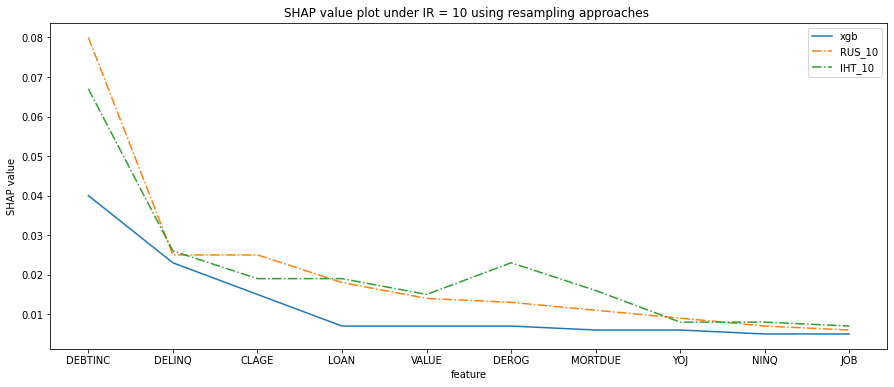

In [81]:
#IR=10 under various approaches
x = shap_top10['feature'].tolist()
xgb_base =shap_top10['xgb'].tolist()

RUS_10 =shap_top10['rus10'].tolist()
IHT_10 =shap_top10['iht10'].tolist()

#plot
plt.rcParams['figure.figsize'] = (15 , 6)

plt.plot(x, xgb_base, label ='xgb')
plt.plot(x, RUS_10, '-.', label ='RUS_10')
plt.plot(x, IHT_10, '-.', label ='IHT_10')


plt.xlabel("feature")
plt.ylabel("SHAP value")
plt.legend()
plt.title('SHAP value plot under IR = 10 using resampling approaches ')
plt.show()

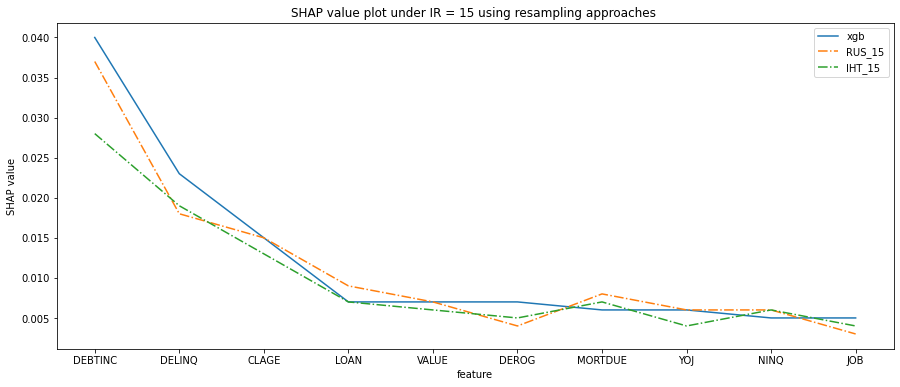

In [82]:
#IR=15 under various approaches
x = shap_top10['feature'].tolist()
xgb_base =shap_top10['xgb'].tolist()

RUS_15 =shap_top10['rus15'].tolist()
IHT_15 =shap_top10['iht15'].tolist()

#plot
plt.rcParams['figure.figsize'] = (15 , 6)

plt.plot(x, xgb_base, label ='xgb')
plt.plot(x, RUS_15, '-.', label ='RUS_15')
plt.plot(x, IHT_15, '-.', label ='IHT_15')


plt.xlabel("feature")
plt.ylabel("SHAP value")
plt.legend()
plt.title('SHAP value plot under IR = 15 using resampling approaches ')
plt.show()

## 6.3 PFI

### 6.3.1 Calculate PFI

In [83]:
instance =xgb_tune.fit(X_train_final, y_train.values.ravel())
pfi_xgb = permutation_importance(xgb_tune, X_train_final, y_train, scoring='roc_auc', n_repeats=5, random_state=1)
pfi_importance = pd.concat([pd.DataFrame(X_train_final.columns),pd.DataFrame(pfi_xgb.importances_mean.round(3))],axis = 1)
pfi_importance = pfi_importance.set_axis(['feature','xgb'], axis='columns')
pfi_importance.head()

,feature,xgb
0,LOAN,0.008
1,MORTDUE,0.008
2,VALUE,0.007
3,YOJ,0.007
4,DEROG,0.001


In [84]:
def pfi_generator(X_data_list, y_data_list, model):
    pfi_list = []
    for X_data, y_data in zip(X_data_list, y_data_list):
        instance_xgb = model.fit(X_data, y_data,eval_set=[(X_val_final, y_val)], early_stopping_rounds= 50)
        pfi_xgb = permutation_importance(model, X_data, y_data, scoring='roc_auc', n_repeats=5, random_state=1)
        pfi_value = pfi_xgb.importances_mean.round(3) 
        pfi_list.append(pfi_value)
    return pfi_list

In [ ]:
pfi_list = pfi_generator(RE_Xlist, RE_ylist,xgb_tune)

In [86]:
#rus1,rus5,rus10,rus15,iht1,iht5,iht10,iht15
pfi_importance['rus1'] = pfi_list[0]
pfi_importance['rus5'] = pfi_list[1]
pfi_importance['rus10'] = pfi_list[2]
pfi_importance['rus15'] = pfi_list[3]
pfi_importance['iht1'] = pfi_list[4]
pfi_importance['iht5'] = pfi_list[5]
pfi_importance['iht10'] = pfi_list[6]
pfi_importance['iht15'] = pfi_list[7]

pfi_importance.head()

,feature,xgb,rus1,rus5,rus10,rus15,iht1,iht5,iht10,iht15
0,LOAN,0.008,0.008,0.010,0.014,0.010,0.015,0.005,0.011,0.009
1,MORTDUE,0.008,0.008,0.007,0.006,0.009,0.042,0.004,0.006,0.013
2,VALUE,0.007,0.011,0.008,0.008,0.009,0.001,0.006,0.005,0.012
3,YOJ,0.007,0.004,0.005,0.005,0.006,0.002,0.007,0.004,0.007
4,DEROG,0.001,0.000,0.000,0.001,0.002,0.003,0.005,0.003,0.004


In [87]:
pfi_importance.to_csv(path + '/pfi_importance.csv', index = True, encoding = 'utf-8-sig') 

### 6.3.2 PFI rank correlation

In [88]:
rank_pfi = pfi_importance.corr(method = 'spearman').round(3)
print(rank_pfi)

         xgb   rus1   rus5  rus10  rus15   iht1   iht5  iht10  iht15
xgb    1.000  0.929  0.926  0.943  0.982  0.759  0.674  0.940  0.938
rus1   0.929  1.000  0.899  0.906  0.936  0.651  0.750  0.858  0.920
rus5   0.926  0.899  1.000  0.986  0.950  0.571  0.614  0.929  0.876
rus10  0.943  0.906  0.986  1.000  0.979  0.640  0.677  0.963  0.902
rus15  0.982  0.936  0.950  0.979  1.000  0.736  0.714  0.968  0.943
iht1   0.759  0.651  0.571  0.640  0.736  1.000  0.547  0.778  0.778
iht5   0.674  0.750  0.614  0.677  0.714  0.547  1.000  0.687  0.751
iht10  0.940  0.858  0.929  0.963  0.968  0.778  0.687  1.000  0.938
iht15  0.938  0.920  0.876  0.902  0.943  0.778  0.751  0.938  1.000


In [89]:
rank_pfi.to_csv(path + '/rank_pfi.csv', index = True, encoding = 'utf-8-sig') 

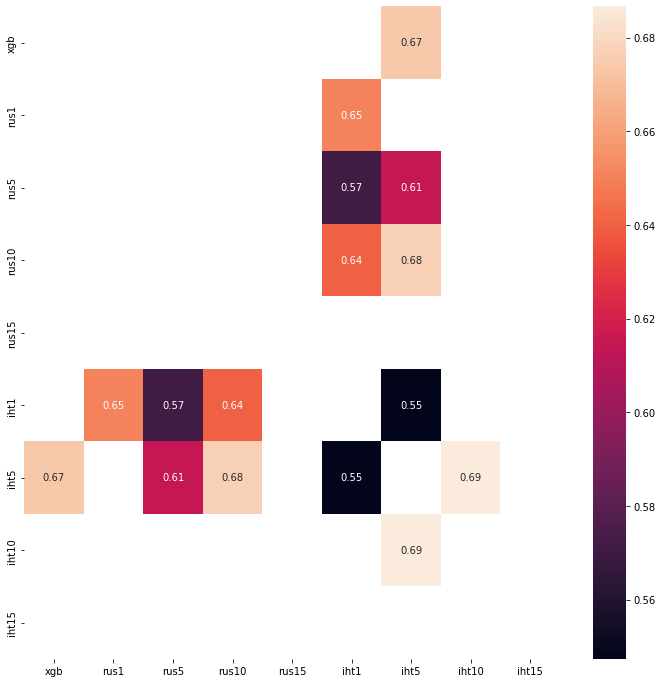

In [90]:
f,ax = plt.subplots(figsize=(12, 12))
snsfilter = sns.heatmap(pfi_importance.corr(method = 'spearman')[(pfi_importance.corr(method = 'spearman') <= 0.695)],
            annot=True);

### 6.3.3 PFI feature importance visualisation

In [91]:
#select top 10 features for original xgb
pfi_top10 = pfi_importance.sort_values(['xgb'], ascending=[False])
pfi_top10 = pfi_top10.head(10)
pfi_top10

,feature,xgb,rus1,rus5,rus10,rus15,iht1,iht5,iht10,iht15
8,DEBTINC,0.047,0.151,0.062,0.078,0.052,0.079,0.024,0.051,0.052
6,CLAGE,0.020,0.011,0.027,0.020,0.025,0.011,0.006,0.013,0.031
5,DELINQ,0.011,0.013,0.007,0.008,0.012,0.126,0.019,0.010,0.027
0,LOAN,0.008,0.008,0.010,0.014,0.010,0.015,0.005,0.011,0.009
1,MORTDUE,0.008,0.008,0.007,0.006,0.009,0.042,0.004,0.006,0.013
2,VALUE,0.007,0.011,0.008,0.008,0.009,0.001,0.006,0.005,0.012
3,YOJ,0.007,0.004,0.005,0.005,0.006,0.002,0.007,0.004,0.007
10,JOB,0.004,0.002,0.003,0.002,0.003,0.001,0.001,0.002,0.003
7,NINQ,0.002,0.002,0.002,0.001,0.002,0.003,0.005,0.002,0.004
4,DEROG,0.001,0.000,0.000,0.001,0.002,0.003,0.005,0.003,0.004


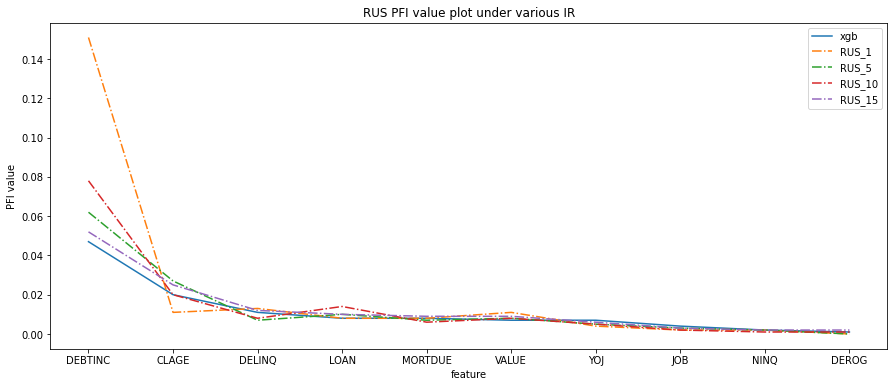

In [92]:
#aggeragate by approaches
#rus under different IR
x = pfi_top10['feature'].tolist()
xgb_base =pfi_top10['xgb'].tolist()
rus_1 =pfi_top10['rus1'].tolist()
rus_5 =pfi_top10['rus5'].tolist()
rus_10 =pfi_top10['rus10'].tolist()
rus_15 =pfi_top10['rus15'].tolist()

#plot
plt.rcParams['figure.figsize'] = (15 , 6)

plt.plot(x, xgb_base, label ='xgb')
plt.plot(x, rus_1, '-.', label ='RUS_1')
plt.plot(x, rus_5, '-.', label ='RUS_5')
plt.plot(x, rus_10, '-.', label ='RUS_10')
plt.plot(x, rus_15, '-.', label ='RUS_15')

plt.xlabel("feature")
plt.ylabel("PFI value")
plt.legend()
plt.title('RUS PFI value plot under various IR')
plt.show()


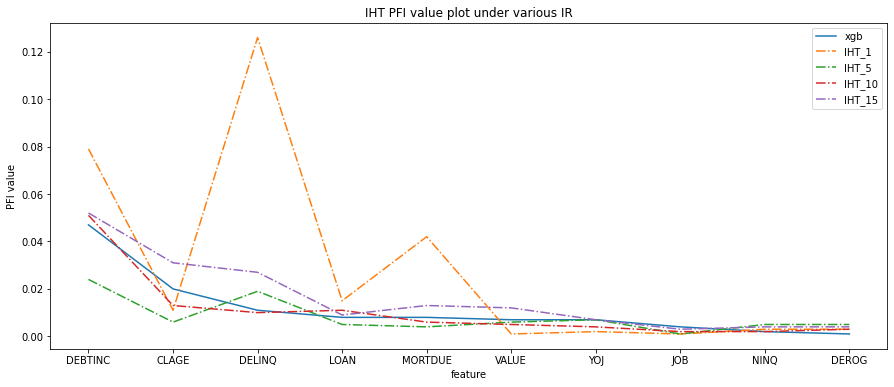

In [93]:
#iht under different IR
x = pfi_top10['feature'].tolist()
xgb_base =pfi_top10['xgb'].tolist()
iht_1 =pfi_top10['iht1'].tolist()
iht_5 =pfi_top10['iht5'].tolist()
iht_10 =pfi_top10['iht10'].tolist()
iht_15 =pfi_top10['iht15'].tolist()

#plot
plt.rcParams['figure.figsize'] = (15 , 6)

plt.plot(x, xgb_base, label ='xgb')
plt.plot(x, iht_1, '-.', label ='IHT_1')
plt.plot(x, iht_5, '-.', label ='IHT_5')
plt.plot(x, iht_10, '-.', label ='IHT_10')
plt.plot(x, iht_15, '-.', label ='IHT_15')

plt.xlabel("feature")
plt.ylabel("PFI value")
plt.legend()
plt.title('IHT PFI value plot under various IR')
plt.show()


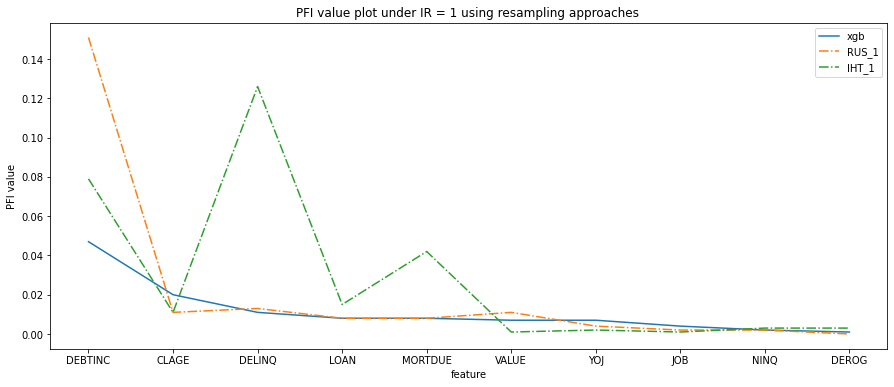

In [94]:
#aggeragate by ratio
#IR=1 under various approaches
x = pfi_top10['feature'].tolist()
xgb_base =pfi_top10['xgb'].tolist()

RUS_1 =pfi_top10['rus1'].tolist()
IHT_1 =pfi_top10['iht1'].tolist()

#plot
plt.rcParams['figure.figsize'] = (15 , 6)

plt.plot(x, xgb_base, label ='xgb')
plt.plot(x, RUS_1, '-.', label ='RUS_1')
plt.plot(x, IHT_1, '-.', label ='IHT_1')


plt.xlabel("feature")
plt.ylabel("PFI value")
plt.legend()
plt.title('PFI value plot under IR = 1 using resampling approaches ')
plt.show()


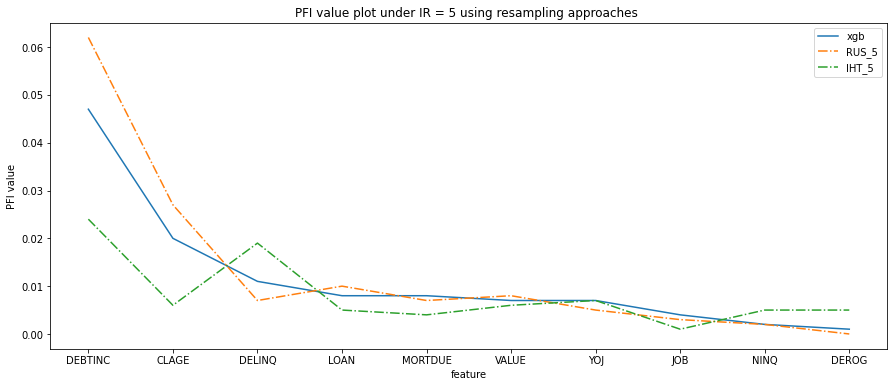

In [95]:
#IR=5 under various approaches
x = pfi_top10['feature'].tolist()
xgb_base =pfi_top10['xgb'].tolist()

RUS_5 =pfi_top10['rus5'].tolist()
IHT_5 =pfi_top10['iht5'].tolist()

#plot
plt.rcParams['figure.figsize'] = (15 , 6)

plt.plot(x, xgb_base, label ='xgb')
plt.plot(x, RUS_5, '-.', label ='RUS_5')
plt.plot(x, IHT_5, '-.', label ='IHT_5')


plt.xlabel("feature")
plt.ylabel("PFI value")
plt.legend()
plt.title('PFI value plot under IR = 5 using resampling approaches ')
plt.show()


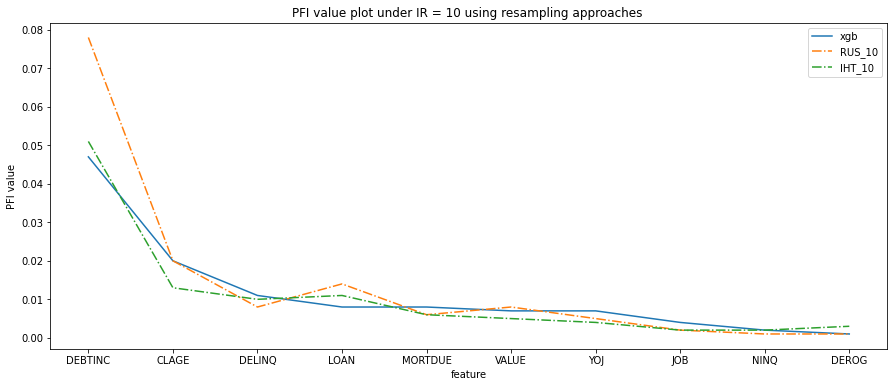

In [96]:
#IR=10 under various approaches
x = pfi_top10['feature'].tolist()
xgb_base =pfi_top10['xgb'].tolist()

RUS_10 =pfi_top10['rus10'].tolist()
IHT_10 =pfi_top10['iht10'].tolist()

#plot
plt.rcParams['figure.figsize'] = (15 , 6)

plt.plot(x, xgb_base, label ='xgb')
plt.plot(x, RUS_10, '-.', label ='RUS_10')
plt.plot(x, IHT_10, '-.', label ='IHT_10')


plt.xlabel("feature")
plt.ylabel("PFI value")
plt.legend()
plt.title('PFI value plot under IR = 10 using resampling approaches ')
plt.show()


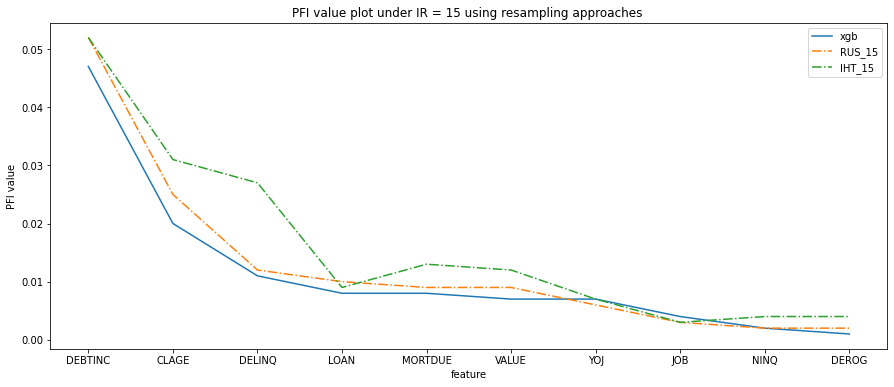

In [97]:
#IR=15 under various approaches
x = pfi_top10['feature'].tolist()
xgb_base =pfi_top10['xgb'].tolist()

RUS_15 =pfi_top10['rus15'].tolist()
IHT_15 =pfi_top10['iht15'].tolist()

#plot
plt.rcParams['figure.figsize'] = (15 , 6)

plt.plot(x, xgb_base, label ='xgb')
plt.plot(x, RUS_15, '-.', label ='RUS_15')
plt.plot(x, IHT_15, '-.', label ='IHT_15')


plt.xlabel("feature")
plt.ylabel("PFI value")
plt.legend()
plt.title('PFI value plot under IR = 15 using resampling approaches ')
plt.show()
